# 2021-03-24 WS3_1 TensorFlow Detecting Handwritten Digits

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/osaukh/mobile_computing_lab/blob/master/2021-03-24__WS3_1__TensorFlow__Detecting_Handwritten_Digits.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/osaukh/mobile_computing_lab/blob/master/2021-03-24__WS3_1__TensorFlow__Detecting_Handwritten_Digits.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
</table>

This is a handwritten character image (MNIST) classifier that can run on any Android device. The app stores a model  set of images (0-9) that we can cycle through and classify in order. It uses a pre-trained model to perform inference on the device. This idea can be applied to any images, both by using the camera and by pulling from the Web. We're using preloaded images so we can run the app in a simulator (no need for the device since it doesn't require a camera).

* <a href="https://www.youtube.com/watch?v=gahi0Hjgokw"><b>Video Demo</b></a>
* <a href="https://github.com/llSourcell/A_Guide_to_Running_Tensorflow_Models_on_Android/tree/master/mnistandroid"><b>App Source Code</b></a>

<img src="https://github.com/llSourcell/A_Guide_to_Running_Tensorflow_Models_on_Android/raw/master/images/demo.png" width="800">


## 1. Building / Training / Testing a Model

### Data 

MNIST is a simple computer vision dataset (70'000 labeled examples). It consists of 28x28 pixel images of handwritten digits. Every MNIST data point, every image, can be thought of as an array of numbers describing how dark each pixel is. For example, we might think of 1 as something like:

<img src="https://tensorflow.rstudio.com/tensorflow/articles/images/MNIST-Matrix.png" width="600">

Since each image has 28 by 28 pixels, we get a 28x28 array. We can flatten each array into a 28∗28=784
 dimensional vector. Each component of the vector is a value between zero and one describing the intensity of the pixel. Thus, we generally think of MNIST as being a collection of 784-dimensional vectors.
 
The __y_train__ data is the associated labels for all the __x_train__ examples. Rather than storing the label as an integer, it is stored as a 1x10 binary array with the one representing the digit. This is also known as one-hot encoding. In the example below, the array represents a 7:

<img src="https://d3ansictanv2wj.cloudfront.net/Img-1-array-b4889b9860c9e009bbd58e827a114129.png" width="600">

In [11]:
import os
import os.path as path

import tensorflow as tf
from tensorflow.python.tools import freeze_graph
from tensorflow.python.tools import optimize_for_inference_lib

import tensorflow.keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K

def load_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
    x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    y_train = tensorflow.keras.utils.to_categorical(y_train, 10)
    y_test = tensorflow.keras.utils.to_categorical(y_test, 10)
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = load_data()

### Exploration

/Users/ahinea/work/pyenv/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  del sys.path[0]


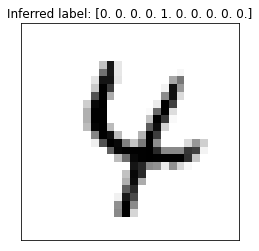

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def display_digit(digit, title = ""):
    """
    graphically displays a 784x1 vector, representing a digit
    """
    plt.figure()
    fig = plt.imshow(digit.flatten().reshape(28,28))
    fig.set_cmap('gray_r')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    if title != "":
        plt.title("Inferred label: " + str(title))
    plt.show()
        
digit = 142
display_digit(x_train[digit], title = y_train[digit])

### Building a Model

Read: <a href="https://hackernoon.com/visualizing-parts-of-convolutional-neural-networks-using-keras-and-cats-5cc01b214e59">Visualizing parts of Convolutional Neural Networks using Keras and Cats</a>

In [16]:
def build_model():
    model = Sequential()
    model.add(Conv2D(filters=64, kernel_size=3, strides=1, \
            padding='same', activation='relu', \
            input_shape=[28, 28, 1]))
    # 28*28*64
    model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
    
    # 14*14*64
    model.add(Conv2D(filters=128, kernel_size=3, strides=1, \
            padding='same', activation='relu'))

    # 14*14*128
    model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
    
    # 7*7*128
    model.add(Conv2D(filters=256, kernel_size=3, strides=1, \
            padding='same', activation='relu'))
    
    # 7*7*256
    model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
    
    # 4*4*256
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
#     model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    return model

model = build_model()

In [17]:
# Display the model's architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 256)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)             

### Training / Testing / Validation

When solving with a CPU an Optimization Problem, you Iteratively apply an Algorithm over some Input Data. In each of these iterations you usually update a Metric of your problem doing some Calculations on the Data. Now when the size of your data is large it might need a considerable amount of time to complete every iteration, and may consume a lot of resources. So sometimes you choose to apply these iterative calculations on a Portion of the Data to save time and computational resources. This portion is the batch_size and the process is called (in the Neural Network Lingo) batch data processing.

In the neural network terminology:
* one __epoch__ = one forward pass and one backward pass of all the training examples
* __batch size__ = the number of training examples in one forward/backward pass. The higher the batch size, the more memory space you'll need.
* number of __iterations__ = number of passes, each pass using [batch size] number of examples. To be clear, one pass = one forward pass + one backward pass (we do not count the forward pass and backward pass as two different passes).

Advantages:
* It requires less memory. Since you train network using less number of samples the overall training procedure requires less memory. It's especially important in case if you are not able to fit dataset in memory.
* Typically networks trains faster with mini-batches. That's because we update weights after each propagation. In our example we've propagated 11 batches (10 of them had 100 samples and 1 had 50 samples) and after each of them we've updated network's parameters. If we used all samples during propagation we would make only 1 update for the network's parameter.

Disadvantages:
* The smaller the batch the less accurate estimate of the gradient. In the figure below you can see that mini-batch (green color) gradient's direction fluctuates compare to the full batch (blue color).

<img src="https://i.stack.imgur.com/lU3sx.png" width="700">

Training code below takes around 5 minutes.

In [20]:
EPOCHS = 1
BATCH_SIZE = 128

model.compile(loss=tensorflow.keras.losses.categorical_crossentropy, \
    optimizer=tensorflow.keras.optimizers.Adam(), \
    metrics=['accuracy'])

checkpoint_path = "ws3_hwd_data/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Train the model with the new callback
model.fit(x_train, y_train, \
        batch_size=BATCH_SIZE, \
        epochs=EPOCHS, \
        verbose=1, \
        validation_data=(x_test, y_test),
        callbacks=[cp_callback])  # Pass callback to training

Train on 60000 samples, validate on 10000 samples
59904/60000 [============================>.] - ETA: 0s - loss: 0.1352 - accuracy: 0.9582
Epoch 00001: saving model to ws3_hwd_data/cp.ckpt
60000/60000 [==============================] - 71s 1ms/sample - loss: 0.1350 - accuracy: 0.9582 - val_loss: 0.0354 - val_accuracy: 0.9878


***
## 2. TensorFlow Lite

#### TensorFlow Lite Converter

We use the TensorFlow Lite converter to convert the model into an optimized one for mobile devices. TensorFlow Lite uses the optimized [FlatBuffers](https://google.github.io/flatbuffers/) format to represent graphs. FlatBuffers play an essential role in efficiently serializing model data and providing quick access to that data while maintaining a small binary size. This is particularly useful for model files that are heavily populated with numerical weight data that can, by virtue of their size, create a lot of latency in read operations. Using FlatBuffer protocols as the basis for this transformation, TensorFlow Lite can bypass a lot of the traditionally expensive file parsing and un-parsing that contributes to slower execution.

Therefore, a TensorFlow model needs to be converted into a FlatBuffer file before deploying it to Android. The TensorFlow Lite converter generates a TensorFlow Lite FlatBuffer file (.tflite) from a TensorFlow model.

In [21]:
converter = tensorflow.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("ws3_hwd_data/converted_model.tflite", "wb").write(tflite_model)

18303964

#### TensorFlow Lite Interpreter

The Interpreter Core is responsible for executing Lite models in client applications using a reduced set of TensorFlow’s operators. By limiting the default operators, libraries, and tools required to run the Lite models, the Interpreter Core has been trimmed to a lean ~100kb alone or ~300kb with all supported kernels.

#### Hardware Acceleration

TensorFlow Lite optimizations reach all the way down to the hardware. Working within the tight constraints of mobile and embedded devices means that processors must be utilized at a hyper-efficient standard. The Android NDK contains a Neural Network API (NNAPI) that provides access to hardware-accelerated inference operations on Android devices. The NNAPI interfaces with TensorFlow Lite to seek out paths for model operations to leverage advantageous hardware where available. With the expectation of machine learning hardware becoming more available on Edge devices, the advantages of the NNAPI framework will become more apparent.

In 2019, the TensorFlow team released support for a GPU backend that will allow for a subset of models and operations to selectively utilize GPUs on mobile devices. The update will benefit models with excess parallelizable work and those that suffer from quantization precision-loss, giving them increases in speed and efficiency (up to 7x for some neural nets). The TensorFlow team promises to increase the set of models and operators currently supported to provide more comprehensive coverage in the future.

#### Quantization

Quantization in TensorFlow Lite refers to the process of reducing operation precision from 32-bit floating point numbers to 8-bit values. Post-training quantization is encouraged in TensorFlow Lite and is provided as an attribute of the TensorFlow Lite Converter during the conversion step. Benchmarking has shown that compressed model inference latency can be reduced up to 3x while maintaining a negligible drop in inference accuracy.

<img src="https://www.tensorflow.org/lite/images/performance/model_size_vs_accuracy.png" width="600"/>
<img src="https://www.tensorflow.org/lite/images/performance/accuracy_vs_latency.png" width="600"/>

Aggregated, these core optimizations provide us a reliable framework within which we can continue to probe the frontiers of on-device machine learning.

***
## 3. Android App

NDK (Native Development Kit) is a tool that allows you to program in C/C++ for Android devices. It integrates with the SDK and is used for performance-critical code.

* <a href="https://developer.android.com/ndk/downloads/">Download and install Android NDK</a> (you should actually get an automatic invitation to install NDK from Android Studio once you try to build an app which requires its support).

![alt text](https://jalammar.github.io/images/android-tensorflow-app-structure_2.png)

* The HandWrittenDigits Android app is provided here: <a href="https://github.com/osaukh/mobile_computing_lab/tree/master/code/HandWrittenDigits">source code</a>. It requires that you use TensorFlow verion > 1.9.1. Examine the code and run it on your hardware. You can also experiment with the model above and use your own model (copy your .tflite file to HandWrittenDigits/app/src/main/assets/).


***
## Credits, Related Examples and Useful Links

* [TensorFlow Lite guide](https://www.tensorflow.org/lite/guide)
* <a href="https://www.oreilly.com/learning/not-another-mnist-tutorial-with-tensorflow">Not another MNIST tutorial with TensorFlow</a>
* <a href="https://heartbeat.fritz.ai/intro-to-machine-learning-on-android-how-to-convert-a-custom-model-to-tensorflow-lite-e07d2d9d50e3">Intro to Machine Learning on Android — How to convert a custom model to TensorFlow Lite</a>
* <a href="https://heartbeat.fritz.ai/introduction-to-machine-learning-on-android-part-2-building-an-app-to-recognize-handwritten-d58ebc01950">Intro to Machine Learning on Android (Part 2): Building an app to recognize handwritten digits with TensorFlow Lite</a>
* Medium [How TensorFlow Lite Optimizes Neural Networks for Mobile Machine Learning](https://heartbeat.fritz.ai/how-tensorflow-lite-optimizes-neural-networks-for-mobile-machine-learning-e6ffa7f8ee12), 2019
* YouTube video by Siraj Raval: <a href="https://www.youtube.com/watch?v=kFWKdLOxykE&feature=youtu.be">A Guide to Running Tensorflow Models on Android</a>
* <a href="https://github.com/llSourcell/A_Guide_to_Running_Tensorflow_Models_on_Android">Original app source code for older versions of TensorFlow (<= 1.5.0)</a> adjusted by Siraj Raval
* Original <a href="https://github.com/miyosuda/TensorFlowAndroidMNIST">app source code</a>